## Protein-Protein Binding Affinity Prediction using Random Forest Regressor

##### Beryl Ramadhian Aribowo 
##### DDP - Master, Kanazawa University

https://github.com/berylgithub

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from math import sqrt

import pickle
import os

In [15]:
'''Dataset Loader'''
def dataset_loader(filepath):
    data = []
    try:
        with open(filepath, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    saved_ids = [d['id'] for d in data]
    return data

dataset = dataset_loader('dataset.pkl')

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 81)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 81)
Testing Labels Shape: (604,)


In [16]:
'''Model Loader'''
with open(os.getcwd()+"/Model/rf_pp_alpha.pkl", "rb") as f:
    rf = pickle.load(f)

In [17]:
'''Model evaluation on training set'''
#Mean Absolute Error
preds = rf.predict(x_train)
errors = abs(preds - y_train)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_train)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_train, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_train, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean Absolute Error: 0.51
Accuracy: 91.97 %.
Root Mean Squared Error : 0.66
Pearson Correlation Coefficient : 0.98


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


No handles with labels found to put in legend.


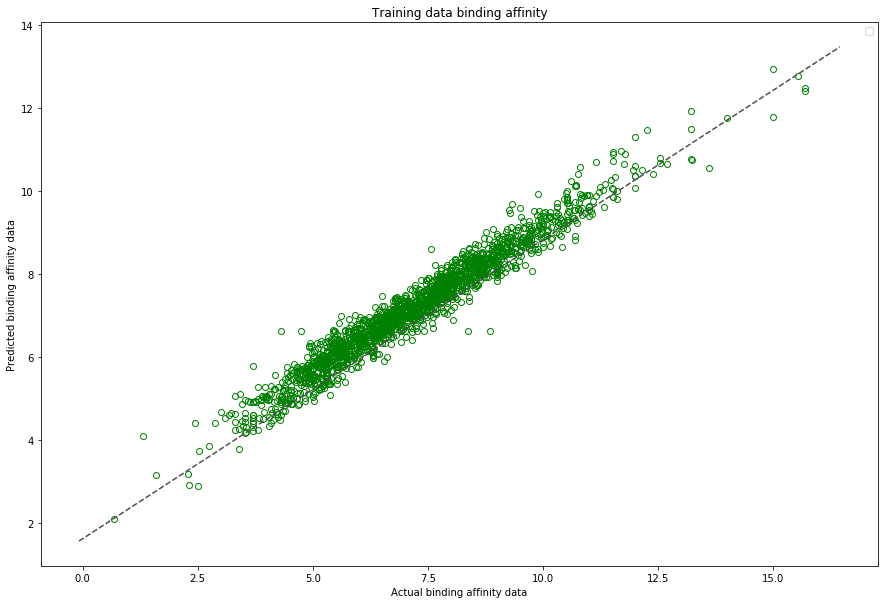

In [18]:
'''Visualization on training set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_train, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.title("Training data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
plt.legend()
plt.show()

In [19]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

Mean Absolute Error: 1.48
Accuracy: 77.12 %.
Root Mean Squared Error : 1.85
Pearson Correlation Coefficient : 0.39


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


No handles with labels found to put in legend.


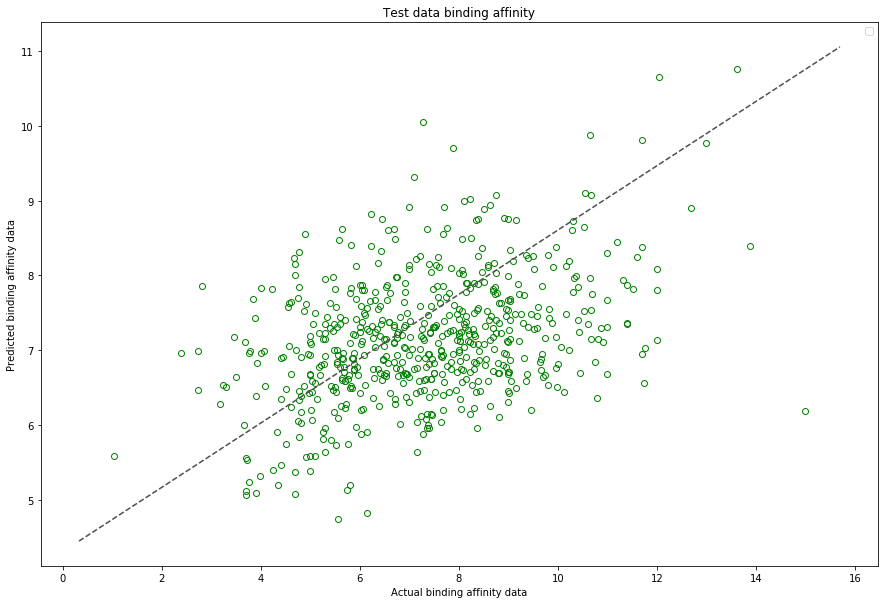

In [20]:
'''Visualization on test set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
plt.legend()
plt.show()


Top 20 Feature ranking:
1. feature 20 (0.079404)
2. feature 0 (0.076925)
3. feature 46 (0.069020)
4. feature 18 (0.068340)
5. feature 5 (0.066554)
6. feature 14 (0.066462)
7. feature 45 (0.064942)
8. feature 2 (0.062842)
9. feature 19 (0.062684)
10. feature 11 (0.062311)
11. feature 47 (0.059928)
12. feature 9 (0.056575)
13. feature 1 (0.053627)
14. feature 10 (0.053063)
15. feature 23 (0.051047)
16. feature 50 (0.046277)
17. feature 26 (0.000000)
18. feature 31 (0.000000)
19. feature 32 (0.000000)
20. feature 30 (0.000000)


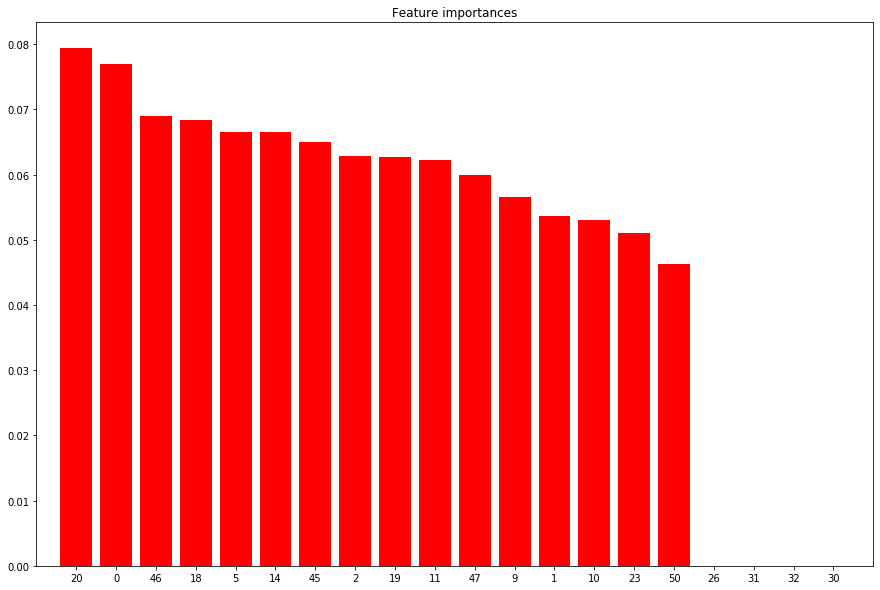

In [25]:
'''
Top 20 features based on combination of:
atom_types = ['C','N','O','F','P','S','Cl','Br','I']
'''

importance = rf.feature_importances_

indices = np.argsort(importance)[::-1][:20]

print("Top 20 Feature ranking:")
#n = importance.shape[0]
n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In [51]:
'''K-Fold model evaluation'''
folds = [3,4,5,7,10]
kfolds=[]
for fold in folds:
    with open(os.getcwd()+"/Model/rf_pp_a_"+str(fold)+"fold_best.pkl", "rb") as f:
        kfolds.append(pickle.load(f))

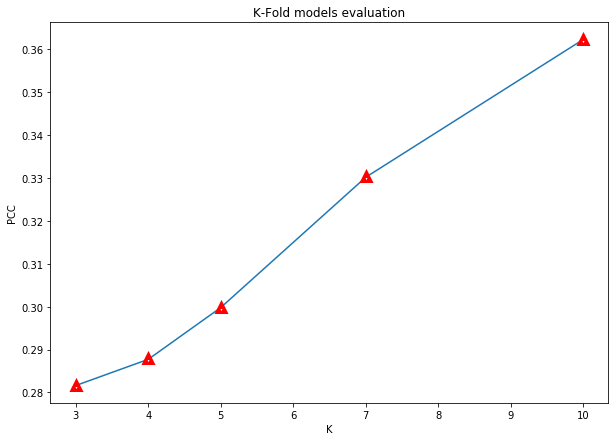

In [64]:
ks = np.array([kfold["k"] for kfold in kfolds])
pcc_tests = np.array([kfold["pcc_test"] for kfold in kfolds])
pcc_trains = np.array([kfold["pcc_train"] for kfold in kfolds])

fig_size = np.zeros(2)
fig_size[0] = 10
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ks, pcc_tests, '^-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5)
plt.title("K-Fold models evaluation")
plt.xlabel('K')
plt.ylabel('PCC')
#plt.legend()
plt.show()

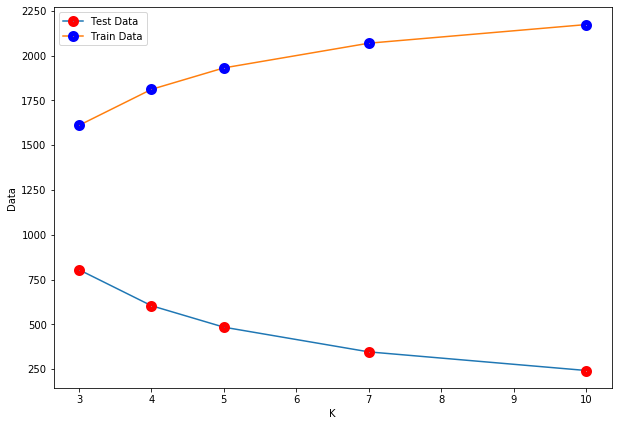

In [70]:
total_train_data = np.array([kfold["train_idx"].shape[0] for kfold in kfolds])
total_test_data = np.array([kfold["test_idx"].shape[0] for kfold in kfolds])
plt.plot(ks, total_test_data,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="Test Data")
plt.plot(ks, total_train_data,'o-', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="Train Data")
plt.xlabel("K")
plt.ylabel("Data")
plt.legend()
plt.show()